#**Deep Pricing - Group 1**

In [ ]:
import numpy as np
import pandas as pd
import math as mt
import random
import torch
from torch.func import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal
from scipy.stats import norm
import enum
import torch.nn as nn
import torch.optim as optim
import time

##**Part I**

###**1.1.1**

In [ ]:
start_time_FD = time.time()

In [ ]:
def GeneratePathsHestonEuler(seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, T, nb_paths, nb_steps):

  np.random.seed(seed)
  dt= T/nb_steps

  s_t = np.zeros((nb_steps + 1, nb_paths))
  v_t = np.zeros((nb_steps + 1, nb_paths))
  s_t[0, :] = S0
  v_t[0, :] = V0

  W_V = np.random.normal(size=(nb_steps, nb_paths))
  W_S = corr_S_V * W_V + np.sqrt(1 - corr_S_V ** 2) * np.random.normal(size=(nb_steps, nb_paths)) #Création d'un BM corrélé à W_V en utilisant la formule du TD

  for j in range(nb_paths):
    for i in range(1,nb_steps+1):
      s_t[i,j]=s_t[i-1,j]+r*s_t[i-1,j]*dt+mt.sqrt(v_t[i-1,j]*dt)*s_t[i-1,j]*W_S[i-1,j]
      v_t[i,j]=abs(v_t[i-1,j]+k*(avg_variance-v_t[i-1,j])*dt+gamma*mt.sqrt(v_t[i-1,j])*W_V[i-1,j])

  return s_t

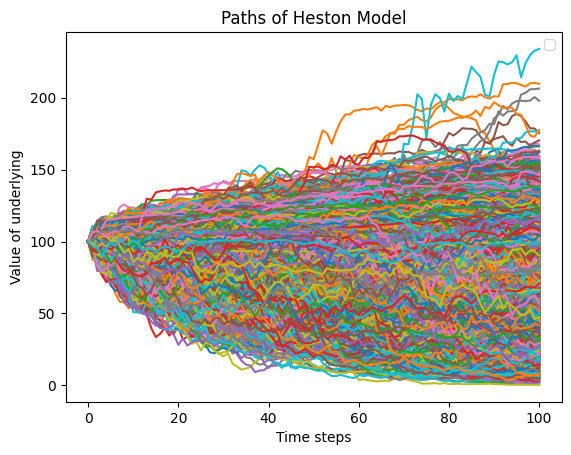

In [ ]:
seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, nb_paths, nb_steps, T = 123, 0.5, 0.1, 0.1, -0.9, 0.02, 100, 0.1, 10000, 100, 1

matrix_Heston_path=GeneratePathsHestonEuler(seed, avg_variance,k,gamma, corr_S_V,r,S0,V0,T,nb_paths, nb_steps)

for col in range(matrix_Heston_path.shape[1]):
    plt.plot(matrix_Heston_path[:, col])

plt.xlabel('Time steps')
plt.ylabel('Value of underlying')
plt.legend()
plt.title('Paths of Heston Model')

plt.show()

###**1.1.2**

In [ ]:
def Payoff(strike, barrier, r, maturity, asset_prices):
  broken_barrier=False
  for price in asset_prices:
    if price<=barrier:
      broken_barrier=True

  if broken_barrier==False:
    payoff=mt.exp(-r*maturity)*max(0,asset_prices[len(asset_prices)-1]-strike)
  else:
    payoff=0

  return payoff

###**1.1.3**

In [ ]:
def MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity):
  matrix_Heston_path=GeneratePathsHestonEuler(seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, maturity, nb_paths, nb_steps)
  matrix_Heston_path=matrix_Heston_path.T
  payoffs=[]
  option_price=[]
  for i in range(nb_paths):
    payoffs.append(Payoff(strike, barrier, r, maturity, matrix_Heston_path[i]))
  option_price= np.mean(payoffs)
  return option_price, payoffs

###**1.1.4**

In [ ]:
def DeltaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity, S_bump, mc_plus_bump, mc):
  delta=(mc_plus_bump - mc)/S_bump
  return delta

def GammaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity, S_bump, mc_plus_bump, mc, mc_moins_bump):
  gamma=(mc_plus_bump-2*mc+mc_moins_bump)/(S_bump**2)
  return gamma

def RhoFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity, r_bump, mc_plus_bump_r, mc):
  rho=(mc_plus_bump_r-mc)/r_bump
  return rho

def VegaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity, v_bump, mc_plus_bump_v, mc):
  vega=(mc_plus_bump_v-mc)/v_bump
  return vega

###**1.1.5**

In [ ]:
delta_final, gamma_final, rho_final, vega_final = [], [], [], []
strike, barrier, seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, nb_paths, nb_steps, T, bumps = 100, 90, 123, 0.5, 0.1, 0.1, -0.9, 0.02, 100, 0.1, 10000, 100, 1, [1,2,3,4,5,6,7,8,9,10]


for i in range(len(bumps)):
  S_bump=bumps[i]
  r_bump=bumps[i]
  v_bump=bumps[i]
  delta_list=[]
  gamma_list=[]
  rho_list=[]
  vega_list=[]

  for j in range(5):
    mc_plus_bump=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0 + S_bump, V0, strike, barrier, T)[0]
    mc=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T)[0]
    mc_moins_bump=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0 - S_bump, V0, strike, barrier, T)[0]
    mc_plus_bump_r=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r + r_bump, S0, V0, strike, barrier, T)[0]
    mc_plus_bump_v=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0+v_bump, strike, barrier, T)[0]

    delta_list.append(DeltaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T, S_bump, mc_plus_bump,mc))
    gamma_list.append(GammaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T, S_bump, mc_plus_bump, mc, mc_moins_bump))
    rho_list.append(RhoFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T, r_bump, mc_plus_bump_r, mc))
    vega_list.append(VegaFD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T, v_bump, mc_plus_bump_v, mc))

  delta_final.append(delta_list)
  gamma_final.append(gamma_list)
  rho_final.append(rho_list)
  vega_final.append(vega_list)

In [ ]:
var_delta, mean_delta, var_gamma, mean_gamma, var_rho, mean_rho, var_vega, mean_vega = [], [], [], [], [], [], [], []

for i in range(len(delta_final)):
  var_delta.append(np.std(delta_final[i])**2)
  mean_delta.append(np.mean(delta_final[i]))
  var_gamma.append(np.std(gamma_final[i])**2)
  mean_gamma.append(np.mean(gamma_final[i]))
  var_rho.append(np.std(rho_final[i])**2)
  mean_rho.append(np.mean(rho_final[i]))
  var_vega.append(np.std(vega_final[i])**2)
  mean_vega.append(np.mean(vega_final[i]))

df_var=pd.DataFrame()
df_var["Var Delta"]=pd.Series(var_delta)
df_var["Var Gamma"]=pd.Series(var_gamma)
df_var["Var Rho"]=pd.Series(var_rho)
df_var["Var Vega"]=pd.Series(var_vega)
df_var.set_index(pd.Index([x*1 for x in bumps]))
df_var

,Var Delta,Var Gamma,Var Rho,Var Vega
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,0.0,0.000000e+00,1.262177e-29,0.000000e+00
3,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,0.0,0.000000e+00,0.000000e+00,0.000000e+00
5,0.0,0.000000e+00,0.000000e+00,0.000000e+00
6,0.0,0.000000e+00,0.000000e+00,0.000000e+00
7,0.0,3.009266e-36,7.888609e-31,1.972152e-31
8,0.0,3.009266e-36,7.888609e-31,1.972152e-31
9,0.0,0.000000e+00,0.000000e+00,0.000000e+00


In [ ]:
df_mean=pd.DataFrame()
df_mean["Mean Delta"]=pd.Series(mean_delta)
df_mean["Mean Gamma"]=pd.Series(mean_gamma)
df_mean["Mean Rho"]=pd.Series(mean_rho)
df_mean["Mean Vega"]=pd.Series(mean_vega)
df_mean

,Mean Delta,Mean Gamma,Mean Rho,Mean Vega
0,0.682023,-0.085327,46.413443,4.174225
1,0.646065,-0.110943,36.794549,1.684263
2,0.642250,-0.078695,26.888348,2.378478
3,0.633984,-0.070890,20.142982,3.045852
4,0.621369,-0.090704,15.562998,3.488409
5,0.756380,-0.045293,12.290298,3.717614
6,0.743635,-0.027344,9.846958,3.794110
7,0.786614,-0.013723,7.958542,3.720951
8,0.770213,-0.013354,6.460663,3.622893
9,0.779795,-0.019911,5.250207,3.439849


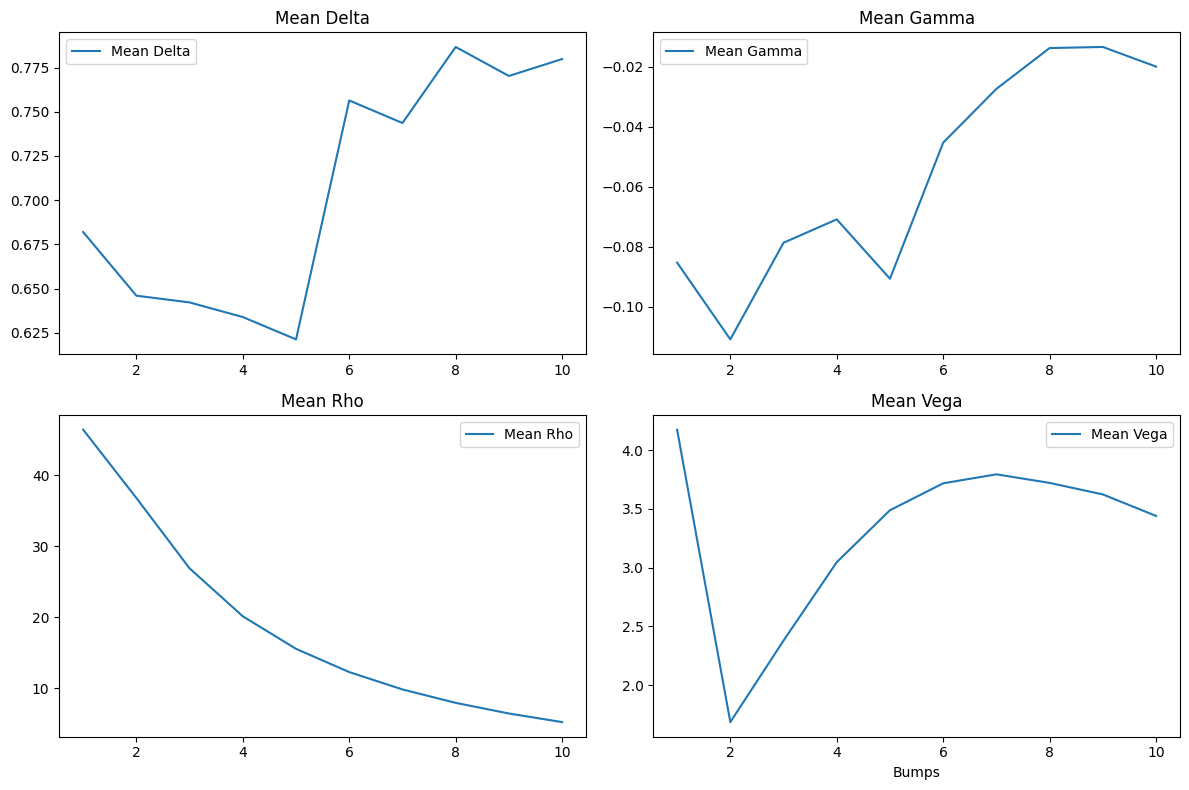

In [ ]:
num_columns = len(df_mean.columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(df_mean.columns):
    row = i // 2
    col = i % 2
    axes[i].plot(bumps, df_mean[column], label=column)
    axes[i].legend()
    axes[i].set_title(column)

plt.xlabel('Bumps')
plt.tight_layout()
plt.show()

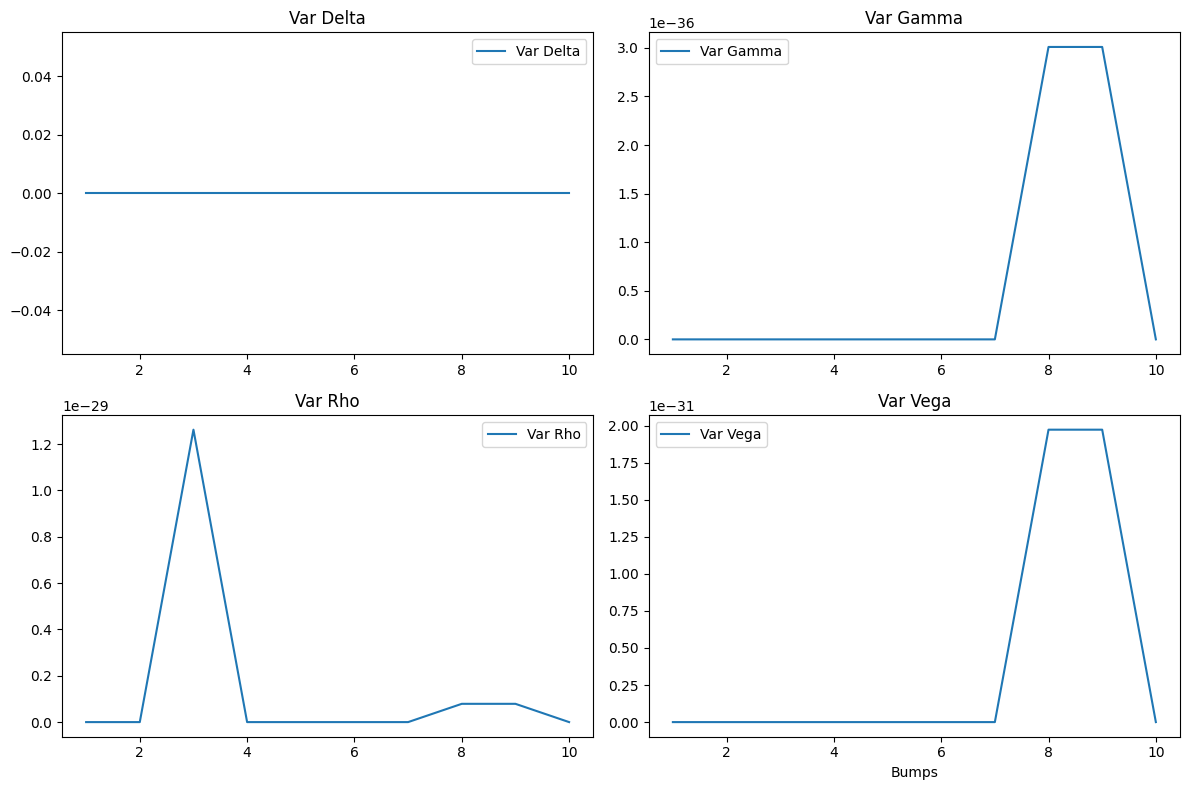

In [ ]:
num_columns = len(df_var.columns)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(df_var.columns):
    row = i // 2
    col = i % 2
    axes[i].plot(bumps, df_var[column], label=column)
    axes[i].legend()
    axes[i].set_title(column)

plt.xlabel('Bumps')
plt.tight_layout()
plt.show()

In [ ]:
greeks_FD=pd.DataFrame({
    "Delta":df_mean['Mean Delta'].mean(),
    "Gamma":df_mean['Mean Gamma'].mean(),
    "Rho":df_mean['Mean Rho'].mean(),
    "Vega":df_mean['Mean Vega'].mean()
}, index=["Value"])

greeks_FD

,Delta,Gamma,Rho,Vega
Value,0.706233,-0.055618,18.760899,3.306664


###**1.1.6**

In [ ]:
def StandardError(nb_paths, payoff):
  standard_error=np.std(payoff)/np.sqrt(nb_paths)
  return standard_error

def StandardDeviation(nb_paths, payoff):
    standard_deviation = np.std(payoff)
    standard_error = standard_deviation / np.sqrt(nb_paths)
    return standard_deviation

In [ ]:
seed=123
avg_variance=0.5
k=0.1
gamma=0.1
corr_S_V=-0.9
r=0.02
S0=100
V0=0.1
nb_steps=100
T=1
strike=100
barrier=90


std_dev_value=[]
standard_errors=[]
payoffs=[]

for nb_paths in range(10,10000,100):
  payoff=MC_Pricing(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, T)[1]
  standard_error=StandardError(nb_paths, payoff)
  standard_errors.append(standard_error)
  std_dv_value=StandardDeviation(nb_paths, payoff)
  std_dev_value.append(std_dv_value)
  payoffs.append(payoff)

std_AAD = max(std_dev_value)

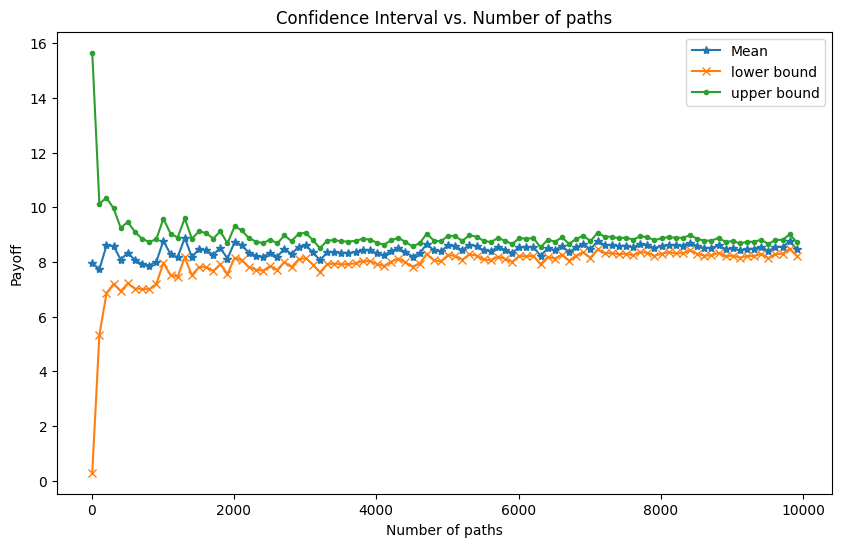

In [ ]:
nb_paths=[x for x in range(10,10000,100)]
lower_bounds=[]
upper_bounds=[]
z=1.96

for i in range(len(standard_errors)):
  lower_bounds.append(np.mean(payoffs[i]) - z * standard_errors[i])
  upper_bounds.append(np.mean(payoffs[i]) + z  * standard_errors[i])

plt.figure(figsize=(10, 6))
plt.plot(nb_paths, [np.mean(payoff) for payoff in payoffs], marker='*', label='Mean')
plt.plot(nb_paths, lower_bounds,marker='x', label='lower bound')
plt.plot(nb_paths, upper_bounds,marker='.', label='upper bound')
plt.xlabel('Number of paths')
plt.ylabel('Payoff')
plt.title('Confidence Interval vs. Number of paths')
plt.legend()
plt.show()

In [ ]:
end_time_FD = time.time()

1704661269.0692172

###**1.1.7**

In [ ]:
#see 1.5 for vega values
df_mean["Mean Vega"].head(5)

0    4.174225
1    1.684263
2    2.378478
3    3.045852
4    3.488409
Name: Mean Vega, dtype: float64

In [ ]:
max_variance_per_bump = [max(vd, vg, vr, vv) for vd, vg, vr, vv in zip(var_delta, var_gamma, var_rho, var_vega)]
std_FD= max(max_variance_per_bump)
#print(std_FD)

###**1.2.1**

In [ ]:
start_time_AAD =  time.time()

In [ ]:
%time

def GeneratePathsHestonEulerAAD(seed, avg_variance,k,gamma, corr_S_V,r,S0,V0,T,nb_paths, nb_steps):
  torch.manual_seed(seed)
  dt=T/nb_steps

  s_t = torch.zeros((nb_steps + 1, nb_paths))
  v_t = torch.zeros((nb_steps + 1, nb_paths))
  s_t[0, :] = S0
  v_t[0, :] = V0

  W_V = torch.normal(0,1,size=(nb_steps, nb_paths))
  W_S = corr_S_V * W_V + torch.sqrt(1 - corr_S_V ** 2) * torch.normal(0,1,size=(nb_steps, nb_paths)) #Création d'un BM corrélé à W_V

  for j in range(nb_paths):
    for i in range(1,nb_steps+1):
      s_t_moins_1=s_t[i-1, j].clone()
      s_t[i, j] = (s_t_moins_1 + r * s_t_moins_1 * dt + torch.sqrt(v_t[i-1, j] * dt) * s_t_moins_1 * W_S[i-1, j])
      v_t[i,j]=torch.abs(v_t[i-1,j]+k*(avg_variance-v_t[i-1,j])*dt+gamma*torch.sqrt(v_t[i-1,j])*W_V[i-1,j])
  return s_t

def PayoffAAD(strike, barrier, r, maturity, asset_prices):
  broken_barrier=False
  for price in asset_prices:
    if price<=barrier:
      broken_barrier=True

  if broken_barrier==False:
    payoff=torch.exp(-r*maturity)*torch.max(torch.tensor(0),asset_prices[len(asset_prices)-1]-strike)
  else:
    payoff=torch.exp(-r*maturity)*torch.max(torch.tensor(0),asset_prices[len(asset_prices)-1]-strike)*torch.tensor(0)
  return payoff

def MC_PricingAAD(seed, nb_paths, nb_steps, avg_variance, k, gamma, corr_S_V, r, S0, V0, strike, barrier, maturity):
  matrix_Heston_path=GeneratePathsHestonEulerAAD(seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, maturity, nb_paths, nb_steps)
  matrix_Heston_path=torch.t(matrix_Heston_path)

  payoffs=torch.zeros((nb_paths))
  for i in range(nb_paths):
    payoffs[i]=PayoffAAD(strike, barrier, r, maturity, matrix_Heston_path[i])
  option_price= torch.mean(payoffs)
  return option_price

seed_tensor=torch.tensor(123)
nb_paths_tensor=torch.tensor(1000)
nb_steps_tensor=torch.tensor(100)

avg_variance_tensor=torch.tensor(0.5)
k_tensor=torch.tensor(0.1)
gamma_tensor=torch.tensor(0.1)
corr_S_V_tensor=torch.tensor(-0.9)
r_tensor = torch.tensor(0.02, requires_grad=True)
S0_tensor=torch.tensor(100., requires_grad=True)
V0_tensor=torch.tensor(0.1, requires_grad=True)
K_tensor = torch.tensor(100.)
B_tensor = torch.tensor(90.)
T_tensor = torch.tensor(1)

price=MC_PricingAAD(seed_tensor, nb_paths_tensor, nb_steps_tensor, avg_variance_tensor, k_tensor, gamma_tensor, corr_S_V_tensor, r_tensor,S0_tensor,V0_tensor, K_tensor, B_tensor, T_tensor)

start_time_GAAD= time.time() #greek computation time
delta = torch.autograd.grad(price, S0_tensor, create_graph=True)
rho=torch.autograd.grad(price, r_tensor, create_graph=True)
vega=torch.autograd.grad(price, V0_tensor, create_graph=True)
gamma = torch.autograd.grad(delta, S0_tensor, allow_unused=True, create_graph=True)
end_time_GAAD= time.time()

greeks_AAD_df=pd.DataFrame({
    "Delta":delta[0].item(),
    "Gamma":gamma[0],
    "Rho":rho[0].item(),
    "Vega":vega[0].item()
}, index=["Value"])

greeks_AAD_df

###**1.2.2**

In [ ]:
vega2=torch.autograd.grad(price, V0_tensor, create_graph=True)
print(vega2)

In [ ]:
end_time_AAD =  time.time()

In [ ]:
df_mean["Mean Vega"] = pd.Series(mean_vega)
lowest_mean_vega = df_mean["Mean Vega"].min()
highest_mean_vega= df_mean["Mean Vega"].max()

print("Lowest Mean Vega:", lowest_mean_vega)
print("Highest Mean Vega:", highest_mean_vega)

In [ ]:
mean_vega_std=np.mean(df_var["Var Vega"])
print("Average Vega Standard Deviation: ", mean_vega_std)

##**Part II**

###**2.1.1**

In [ ]:
seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, nb_paths, nb_steps, T, strike, barrier = 123, 0.5, 0.1, 0.1, -0.9, 0.02, 100, 0.1, 20, 100, 1, 100, 90

In [ ]:
def GeneratePathsHestonEuler(seed, avg_variance,k,gamma, corr_S_V,r,S0,V0,T,nb_paths, nb_steps):
  dt=T/nb_steps
  matrix_Heston_paths=np.array([])
  s_t = np.zeros((nb_steps + 1, nb_paths))
  v_t = np.zeros((nb_steps + 1, nb_paths))
  s_t[0, :] = S0
  v_t[0, :] = V0

  W_V = np.random.normal(size=(nb_steps, nb_paths))
  W_S = corr_S_V * W_V + np.sqrt(1 - corr_S_V ** 2) * np.random.normal(size=(nb_steps, nb_paths)) #Création d'un BM corrélé à W_V

  for j in range(nb_paths):
    for i in range(1,nb_steps+1):
      s_t[i,j]=s_t[i-1,j]+r*s_t[i-1,j]*dt+np.sqrt(v_t[i-1,j]*dt)*s_t[i-1,j]*W_S[i-1,j]
      v_t[i,j]=abs(v_t[i-1,j]+k*(avg_variance-v_t[i-1,j])*dt+gamma*np.sqrt(v_t[i-1,j])*W_V[i-1,j])

  return s_t

In [ ]:
def Payoff(strike, barrier, r, maturity, asset_prices):
  broken_barrier=False
  for price in asset_prices:
    if price<=barrier:
      broken_barrier=True

  if broken_barrier==False:
    payoff=np.exp(-r*maturity)*max(0,asset_prices[len(asset_prices)-1]-strike)
  else:
    payoff=0.
  return payoff

In [ ]:
def GeneratePathsHestonEulerAAD(seed, avg_variance,k,gamma, corr_S_V,r,S0,V0,T,nb_paths, nb_steps):
  torch.autograd.set_detect_anomaly(True)
  dt=T/nb_steps

  s_t = torch.zeros((nb_steps + 1, nb_paths))
  v_t = torch.zeros((nb_steps + 1, nb_paths))
  s_t[0, :] = S0
  v_t[0, :] = V0

  W_V = torch.normal(0,1,size=(nb_steps, nb_paths))
  W_S = corr_S_V * W_V + torch.sqrt(1 - corr_S_V ** 2) * torch.normal(0,1,size=(nb_steps, nb_paths)) #Création d'un BM corrélé à W_V

  for j in range(nb_paths):
    for i in range(1,nb_steps+1):
      s_t_moins_1=s_t[i-1, j].clone()
      s_t[i, j] = (s_t_moins_1 + r * s_t_moins_1 * dt + torch.sqrt(v_t[i-1, j] * dt) * s_t_moins_1 * W_S[i-1, j])
      v_t[i,j]=torch.abs(v_t[i-1,j]+k*(avg_variance-v_t[i-1,j])*dt+gamma*torch.sqrt(v_t[i-1,j])*W_V[i-1,j])
  #print(s_t)
  return s_t

def PayoffAAD(strike, barrier, r, maturity, asset_prices):
  broken_barrier=False
  for price in asset_prices:
    if price<=barrier:
      broken_barrier=True

  if broken_barrier==False:
    payoff=torch.exp(-r*maturity)*torch.max(torch.tensor(0),asset_prices[len(asset_prices)-1]-strike)
  else:
    payoff=torch.tensor(0)*torch.exp(-r*maturity)*torch.max(torch.tensor(0),asset_prices[len(asset_prices)-1]-strike)
  return payoff

In [ ]:
seed_tensor=torch.tensor(123)
nb_paths_tensor=torch.tensor(20)
nb_steps_tensor=torch.tensor(100)
avg_variance_tensor=torch.tensor(0.5)
k_tensor=torch.tensor(0.1)
gamma_tensor=torch.tensor(0.1)
corr_S_V_tensor=torch.tensor(-0.9)
r_tensor = torch.tensor(0.02, requires_grad=True)
S0_tensor=torch.tensor(100., requires_grad=True)
V0_tensor=torch.tensor(0.1)
K_tensor = torch.tensor(100.)
B_tensor = torch.tensor(90.)
T_tensor = torch.tensor(1)

In [ ]:
def HestonLSM(seed_tensor, avg_variance_tensor,k_tensor,gamma_tensor, corr_S_V_tensor,r_tensor,S0_tensor,V0_tensor,T_tensor,nb_paths_tensor, nb_steps_tensor, K_tensor, B_tensor):

  matrix_Heston_path=GeneratePathsHestonEulerAAD(seed_tensor, avg_variance_tensor,k_tensor,gamma_tensor, corr_S_V_tensor,r_tensor,S0_tensor,V0_tensor,T_tensor,nb_paths_tensor, nb_steps_tensor)
  matrix_Heston_path=torch.t(matrix_Heston_path)
  print("Nb paths: ", len(matrix_Heston_path))

  payoffs=torch.zeros((nb_paths_tensor))
  gradients = torch.zeros_like(payoffs)
  for i in range(nb_paths_tensor):
    payoffs[i]=PayoffAAD(K_tensor, B_tensor, r_tensor, T_tensor, matrix_Heston_path[i])
  X = matrix_Heston_path[1, :]
  return X.reshape([-1, 1]), payoffs, gradients

X,Y,dYdX=HestonLSM(seed_tensor, avg_variance_tensor,k_tensor,gamma_tensor, corr_S_V_tensor,r_tensor,S0_tensor,V0_tensor,T_tensor,nb_paths_tensor, nb_steps_tensor, K_tensor, B_tensor)
#print(X)

In [ ]:
print(Y)

###**2.1.2**

In [ ]:
def normalize_data(X, Y, dYdX):
    X_mean, X_std = torch.mean(X), torch.std(X)
    Y_mean, Y_std = torch.mean(Y), torch.std(Y)
    dYdX_mean, dYdX_std = torch.mean(dYdX), torch.std(dYdX)
    X_normalized = (X-X_mean)/X_std
    Y_normalized = (Y-Y_mean)/Y_std
    dYdX_normalized = (dYdX-dYdX_mean)/dYdX_std
    n = len(X_normalized)
    lambda_j =1/torch.sqrt((1/n)*torch.sum(dYdX_normalized**2))

    return X_normalized,X_mean, X_std, Y_normalized, Y_mean, Y_std, dYdX_normalized, lambda_j

In [ ]:
X_normalized,X_mean, X_st, Y_normalized,Y_mean,Y_std,dYdX_normalized,lambda_j = normalize_data(X, Y, dYdX)

###**2.2**

In [ ]:
start_time_NN =  time.time()

In [ ]:
class TwinNetwork(nn.Module):
    def __init__(self, input_size):
        super(TwinNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.out = nn.Linear(20, 1)

        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='linear')

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

    def predict_price(self, X, X_mean, X_std, Y_mean, Y_std):
        X_norm = (X - X_mean) / X_std
        Y_pred = self.forward(X_norm)
        Y_pred_unscaled = (Y_pred * Y_std) + Y_mean

        return Y_pred_unscaled

    def predict_price_and_diffs(self, X, X_mean, X_std, Y_mean, Y_std):
        X_norm = (X - X_mean) / X_std
        X_norm.requires_grad_(True)
        Y_pred = self.forward(X_norm)
        self.zero_grad()
        Y_pred.backward(torch.ones_like(Y_pred))
        dYdX = X_norm.grad
        Y_pred_unscaled = (Y_pred.detach() * Y_std) + Y_mean
        dYdX_unscaled = dYdX * Y_std / X_std

        return Y_pred_unscaled, dYdX_unscaled

twin_network = TwinNetwork(input_size=1)

X_sample = torch.tensor(X).float()
X_mean, X_std = torch.mean(X_sample).float(), torch.std(X_sample).float()
Y = torch.tensor(Y)
Y_mean, Y_std = torch.mean(Y), torch.std(Y)

In [ ]:
predicted_price = twin_network.predict_price(X_sample, X_mean, X_std, Y_mean, Y_std)
#print(predicted_price)

In [ ]:
predicted_price2, price_diffs = twin_network.predict_price_and_diffs(X_sample, X_mean, X_std, Y_mean, Y_std)

###**2.3**

In [ ]:
def training(network, X_train, Y_train, dYdX_train, lambda_j, epochs, scenario):
    if scenario not in [1, 2]:
        raise ValueError("Choose 1 for training without differentials or 2 with differentials.")

    if scenario == 2:
        X_train = X_train.clone().detach().requires_grad_(True)
        N = X_train.size(1)#nbr of inputs
        alpha = 1/(1 + N)
    else:
        alpha = None

    criterion = nn.MSELoss() #  MSE
    optimizer = optim.Adam(network.parameters(), lr=0.1) # ADAM OPTIMISER (learning rate =0.1)
    cost_per_epoch = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        Y_pred = network(X_train)

        if scenario== 1:
            loss = criterion(Y_pred, Y_train)
        else:
            Y_pred.backward(torch.ones_like(Y_pred), retain_graph=True)
            dYdX_pred = X_train.grad
            loss_Y = criterion(Y_pred, Y_train)
            print('Y', loss_Y)
            loss_dYdX = criterion(dYdX_pred, dYdX_train)
            print('DYDX', loss_dYdX)
            loss = alpha*loss_Y+(1-alpha)*loss_dYdX
            X_train.grad.zero_()

        loss.backward() #backpropagate
        optimizer.step()
        cost_per_epoch.append(loss.item())

    return cost_per_epoch

###**2.4.1**

In [ ]:
def HestonLSM2(seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, T, nb_paths, nb_steps, strike, barrier):
    #torch.random.seed(seed)
    matrix_Heston_path = GeneratePathsHestonEulerAAD(seed, avg_variance, k, gamma, corr_S_V, r, S0, V0, T, nb_paths, nb_steps)
    S_Heston = matrix_Heston_path
    payoff = torch.zeros(len(S_Heston))
    epsilon = torch.tensor(0.00001)
    dYdX = torch.zeros(len(S_Heston))

    for i in range(len(S_Heston)):
        Y_plus = PayoffAAD(strike, barrier, r, T, S_Heston[:, i] + epsilon)
        Y_minus = PayoffAAD(strike, barrier, r, T, S_Heston[:, i] - epsilon)
        dYdX_i = (Y_plus-Y_minus)/(2*epsilon)
        payoff[i] = PayoffAAD(strike, barrier, r, T, S_Heston[:, i])
        dYdX[i] = dYdX_i

    X = S_Heston[1, :] # state

    return X.reshape([-1, 1]), payoff, dYdX

In [ ]:
seed_tensor=torch.tensor(123)
nb_paths_tensor=torch.tensor(1000)
nb_steps_tensor=torch.tensor(10)
avg_variance_tensor=torch.tensor(0.5)
k_tensor=torch.tensor(0.1)
gamma_tensor=torch.tensor(0.1)
corr_S_V_tensor=torch.tensor(-0.9)
r_tensor = torch.tensor(0.02, requires_grad=True)
S0_tensor=torch.tensor(100., requires_grad=True)
V0_tensor=torch.tensor(0.1)
K_tensor = torch.tensor(100.)
B_tensor = torch.tensor(90.)
T_tensor = torch.tensor(1)

In [ ]:
X2,Y2,dYdX2 = HestonLSM2(seed_tensor, avg_variance_tensor,k_tensor,gamma_tensor, corr_S_V_tensor,r_tensor,S0_tensor,V0_tensor,T_tensor,nb_paths_tensor, nb_steps_tensor, K_tensor, B_tensor)

###**2.4.2**

In [ ]:
X2_normalized, X2_M, X2_S, Y2_normalized,Y2_M,Y2_S, dYdX2_normalized,lambda_j2 = normalize_data(X2, Y2, dYdX2)

###**2.4.3**

In [ ]:
twin_network = TwinNetwork(input_size=1)

X2_sample = torch.tensor(X2).float()
X2_mean, X2_std = torch.mean(X2_sample).float(), torch.std(X2_sample).float()
Y2 = torch.tensor(Y2)
Y2_mean, Y2_std = torch.mean(Y2), torch.std(Y2)
predicted_price2 = twin_network.predict_price(X2_sample, X2_mean, X2_std, Y2_mean, Y2_std)

predicted_price2, price_diffs2 = twin_network.predict_price_and_diffs(X2_sample, X2_mean, X2_std, Y2_mean, Y2_std)

###**2.4.4**

In [ ]:
costs_classical_neural_network = training(twin_network, torch.tensor(X2_normalized).float(), torch.tensor(Y2_normalized).float(), torch.tensor(dYdX2_normalized).float(), lambda_j2, epochs=100, scenario=1)
costs_differential_neural_network = training(twin_network, torch.tensor(X2_normalized).float(), torch.tensor(Y2_normalized).float(), torch.tensor(dYdX2_normalized).float(), lambda_j2, epochs=100, scenario=2)

In [ ]:
plt.plot(costs_differential_neural_network, label='Differential Neural Network')
plt.plot(costs_classical_neural_network, label='Classical Neural Network')
plt.legend(title='Cost')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(Y2,label='Payoff')
plt.plot(dYdX2.detach().numpy(),label = 'dYdX')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
%time
delta = torch.autograd.grad(Y2_M, S0_tensor, create_graph=True)

In [ ]:
%time
rho=torch.autograd.grad(Y2_M, r_tensor, create_graph=True)

In [ ]:
%time
gamma = torch.autograd.grad(torch.mean(dYdX2), S0_tensor, create_graph=True)

In [ ]:
greeks = pd.DataFrame({'Delta':[delta[0].detach().numpy()],
                       'rho':[rho[0].detach().numpy()],
                       'gamma':[gamma[0].detach().numpy()]})

In [ ]:
greeks.T

In [ ]:
end_time_NN =  time.time()

###**2.4.5**

In [ ]:
class TwinNetwork(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(TwinNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(20, 20)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(20, 20)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(20, 20)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(20, 1)


    def forward(self, x, apply_dropout=False):
        x = F.relu(self.fc1(x))
        if apply_dropout: x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        if apply_dropout: x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        if apply_dropout: x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        if apply_dropout: x = self.dropout4(x)
        x = self.out(x)
        return x

    def predict_price(self, X, X_mean, X_std, Y_mean, Y_std, apply_dropout=False):
        X_norm = (X - X_mean) / X_std
        Y_pred = self.forward(X_norm, apply_dropout=apply_dropout)
        Y_pred_unscaled = (Y_pred * Y_std) + Y_mean
        return Y_pred_unscaled

    def predict_price_and_diffs(self, X, X_mean, X_std, Y_mean, Y_std):
        X_norm = (X - X_mean) / X_std
        X_norm.requires_grad_(True)
        Y_pred = self.forward(X_norm)

        self.zero_grad()
        Y_pred.backward(torch.ones_like(Y_pred))
        dYdX = X_norm.grad

        Y_pred_unscaled = (Y_pred.detach() * Y_std) + Y_mean
        dYdX_unscaled = dYdX * Y_std / X_std

        return Y_pred_unscaled, dYdX_unscaled


In [ ]:
def uncertainty_calculation(model, X, X_mean, X_std, Y_mean, Y_std, n_iterations=100):
    predictions = []
    for i in range(n_iterations):
        Y_pred_unscaled = model.predict_price(X, X_mean, X_std, Y_mean, Y_std, apply_dropout=True)
        predictions.append(Y_pred_unscaled.detach().numpy())

    predictions = np.array(predictions)
    uncertainty = np.std(predictions, axis=0)

    return uncertainty

uncertainty = uncertainty_calculation(twin_network, X, X_mean, X_std, Y_mean, Y_std)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(uncertainty, bins=30, color='blue', alpha=0.7)
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Uncertainties')
plt.grid(True)
plt.show()


##**PART III**

###**3.3**

In [ ]:
number_of_runs = 10  # Number of simulations
epoch_count = 100
scenario = 1
avg_variance_tensor = torch.tensor(0.5)
k_tensor = torch.tensor(0.1)
gamma_tensor = torch.tensor(0.1)
corr_S_V_tensor = torch.tensor(-0.9)
r_tensor = torch.tensor(0.02, requires_grad=True)
S0_tensor = torch.tensor(100., requires_grad=True)
V0_tensor = torch.tensor(0.1)
K_tensor = torch.tensor(100.)
B_tensor = torch.tensor(90.)
T_tensor = torch.tensor(1)
nb_paths_tensor = torch.tensor(11)
nb_steps_tensor = torch.tensor(10)

final_costs = []

for seed in range(number_of_runs):
    seed_tensor = torch.tensor(seed)
    X2, Y2, dYdX2 = HestonLSM2(seed_tensor, avg_variance_tensor, k_tensor, gamma_tensor, corr_S_V_tensor, r_tensor, S0_tensor, V0_tensor, T_tensor, nb_paths_tensor, nb_steps_tensor, K_tensor, B_tensor)
    X2_normalized, X2_M, X2_S, Y2_normalized, Y2_M, Y2_S, dYdX2_normalized, lambda_j2 = normalize_data(X2, Y2, dYdX2)
    twin_network = TwinNetwork(input_size=1)
    X2_sample = torch.tensor(X2).float()
    Y2 = torch.tensor(Y2)
    costs = training(twin_network, torch.tensor(X2_normalized).float(), torch.tensor(Y2_normalized).float(), torch.tensor(dYdX2_normalized).float(), lambda_j2, epochs=epoch_count, scenario=scenario)
    final_costs.append(costs[-1])

std_NN = np.max(final_costs)

In [ ]:
results = {"FD": {}, "AAD": {}, "NN": {}}
results["FD"]["Computation Time"] = round(end_time_FD - start_time_FD, 3)
results["AAD"]["Computation Time"] = round(end_time_AAD - start_time_AAD, 3)
results["NN"]["Computation Time"] = round(end_time_NN - start_time_NN, 3)

results["FD"]["Greek Calculation Time"] = round(end_time_GFD - start_time_GFD, 3)
results["AAD"]["Greek Calculation Time"] = round(end_time_GAAD - start_time_GAAD, 3)
results["NN"]["Greek Calculation Time"] = round(end_time_GNN - start_time_GNN, 3)

results["FD"]["Uncertainty"] = std_FD
results["AAD"]["Uncertainty"] = std_AAD
results["NN"]["Uncertainty"] = std_NN


print(results)